In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns

In [33]:
df = pd.read_csv('/workspaces/ProyectoV_Ind_Oro/src/PIV_Oro/static/data/Oro_datosOriginales_enricher.csv', sep=';', parse_dates=['fecha'])

In [34]:
df = df[["fecha", "cierre_ajustado"]]
df.set_index('fecha', inplace=True)
df.head()


,cierre_ajustado
fecha,
2025-05-23,3363.6
2025-05-22,3292.3
2025-05-21,3309.3
2025-05-20,3280.3
2025-05-19,3228.9


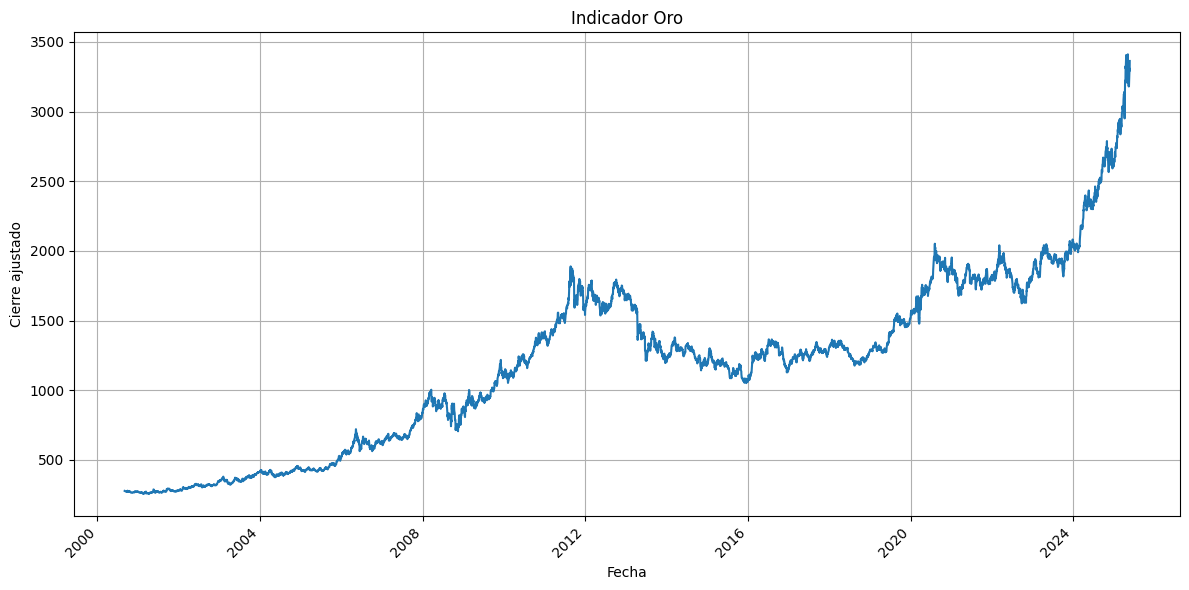

In [24]:
plt.figure(figsize=(12, 6))
df['cierre_ajustado'].plot(figsize=(12, 6), label='Cierre ajustado')
plt.title('Indicador Oro')
plt.xlabel('Fecha')
plt.ylabel('Cierre ajustado')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1. Crecimiento inicial (2000 - 2011)
Entre 2000 y 2011, el precio del oro sube constantemente.
2. Corrección y estancamiento (2012 - 2016)
Después del pico en 2011, el oro baja significativamente y se mantiene en una especie de meseta hasta 2016.

Esto suele pasar cuando las economías comienzan a estabilizarse y el dólar se fortalece.

3. Nueva escalada (2018 - 2020)
Vuelve a subir en 2019 y pega un buen salto en 2020.

 En tiempos de pandemia, otra vez el oro se vuelve protagonista. Vemos una subida fuerte hasta rozar los 2,000 USD otra vez.

4. Consolidación con altibajos (2021 - 2023)
Entre 2021 y 2023 hay subidas y bajadas, pero se mantiene fuerte, sin perder el nivel de los 1,700-1,900 USD.

5. Subida explosiva (finales de 2023 - 2025)
El oro se dispara verticalmente como cohete en pleno despegue, alcanzando un valor por encima de los 3,400 USD en 2025.

¿Qué podría causar esto? Crisis geopolíticas, inflación extrema, impresión de dinero masiva por bancos centrales, o caída de la confianza en el dólar.


modelo escogido  RMSE 

In [ ]:
class Modelador:
    def __init__(self, path_csv='/workspaces/ProyectoV_Ind_Oro/src/PIV_Oro/static/data/Oro_datosOriginales_enricher.csv'):
        self.path_csv = path_csv
        self.model_path = 'static/models/model.pkl'
        self.model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.X_test = None
        self.y_test = None
        self.y_pred = None

    def cargar_datos(self):
        df = pd.read_csv(self.path_csv, sep=';', parse_dates=['fecha'])
        df = df.sort_values(by='fecha')  # ordena por tiempo
        df = df.dropna()  # elimina filas con valores faltantes
        return df

    def entrenar(self):
        df = self.cargar_datos()

        # Seleccionamos características predictoras
        X = df[['abrir', 'max', 'min', 'volumen', 'media_movil_7d',
                'tasa_variacion', 'retorno_acumulado', 'std_5d', 'volatilidad']]
        y = df['cerrar']

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Entrenamiento del modelo
        self.model.fit(self.X_train, self.y_train)

        # Validamos
        self.y_pred = self.model.predict(self.X_test)
        mse = mean_squared_error(self.y_test, self.y_pred)
        rmse = np.sqrt(mse)

        print(f'RMSE del modelo: {rmse:.2f}')

        # Justificación:
        # Usamos RMSE porque penaliza más fuertemente los errores grandes, lo cual es útil en series financieras
        # donde un error de 100 puede ser mucho peor que 10 errores de 10.

        # Guarda el modelo
        os.makedirs(os.path.dirname(self.model_path), exist_ok=True)
        with open(self.model_path, 'wb') as f:
            pickle.dump(self.model, f)

        print(f"Modelo guardado en {self.model_path}")

    def predecir(self, nuevos_datos: pd.DataFrame):
        # Carga el modelo entrenado
        with open(self.model_path, 'rb') as f:
            modelo = pickle.load(f)

        # columnas de entrenamiento
        columnas = ['abrir', 'max', 'min', 'volumen', 'media_movil_7d',
                    'tasa_variacion', 'retorno_acumulado', 'std_5d', 'volatilidad']
        predicciones = modelo.predict(nuevos_datos[columnas])
        return predicciones

    def visualizar_predicciones(self):
        if self.y_test is None or self.y_pred is None:
            print("Por favor, entrena el modelo primero para generar las predicciones y los valores de prueba.")
            return

        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=self.y_test, y=self.y_pred, alpha=0.6)
        plt.plot([self.y_test.min(), self.y_test.max()], [self.y_test.min(), self.y_test.max()], 'r--', lw=2)
        plt.xlabel("Precio Real del Oro")
        plt.ylabel("Precio Predicho del Oro")
        plt.title("Precios Reales vs. Predicciones del Modelo de Oro")
        plt.grid(True)
        plt.show()

RMSE del modelo: 2.57
Modelo guardado en static/models/model.pkl


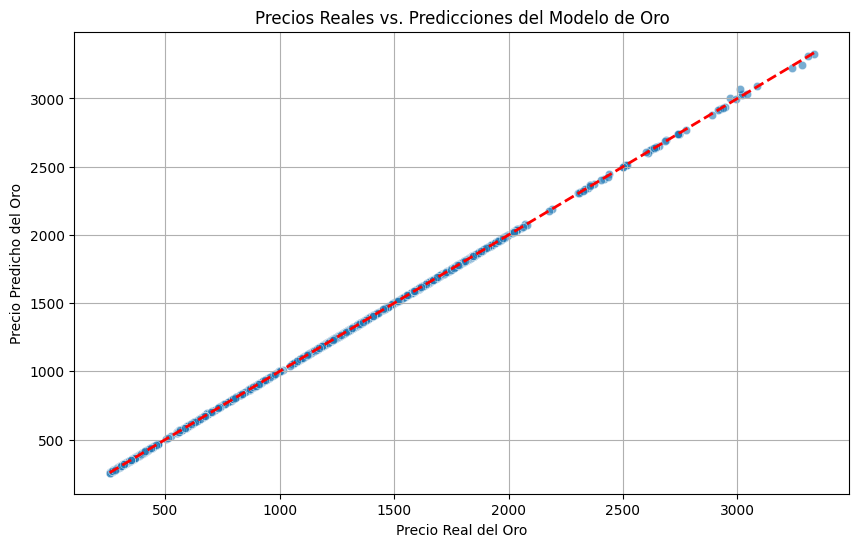

In [45]:
modelo = Modelador()
modelo.entrenar()
modelo.visualizar_predicciones()

Justificación de RMSE: el RMSE es una métrica de error útil para regresión, ya que en este caso
Está en la misma unidad que la variable objetivo (el precio del oro). Un RMSE de 2.57 significa que, en promedio, las predicciones del modelo se desvían de los valores reales por aproximadamente 2.57 unidades monetarias (dólares, por ejemplo, que en este caso es el precio  del oro).
Penaliza más los errores grandes: Al elevar al cuadrado las diferencias, los errores más grandes tienen un impacto desproporcionadamente mayor en el RMSE. En el cuando hablamos financieramente,(como el precio del oro), un error grande puede ser mucho más costoso o significativo que varios errores pequeños. Un RMSE bajo (como 2.57,(en nuestro caso) dependiendo de la escala de los precios de oro) es una señal de un buen rendimiento.